Continuar a partir da aula (Aula 02 - Entenda o problema de negócio com 4 perguntas)

## Problema de negócio:

O CFO da empresa fez uma reunião com todos os Gerentes de Loja e pediu para que cada um deles trouxesse uma previsão diária das próximas 6 semanas de vendas.

Depois dessa reunião, todos os Gerentes entraram em contato com você requisitando uma previsão de vendas de sua loja. 

Topicos para entender o problema:

1. A motivação (Qual o contexto)?

2. A causa raiz do problema (Pra que fazer isso)?

3. Qual é o dono do problema (Quem está requisitando)?

4. Formato da solução (Como será entregue? Qual granularidade?)

### CRISP - DS

* Cross-Insdutry Process - Data Science

* Método Cíclico de Desenvimento

1. Ciclo completo:

    - 1 Versão End-to-End da Solução.
    - Velocidade na Entrega de Valor.
    - Mapeamento de todos os possíveis problemas.

### Ciclo CRISP-DS

    A[Questão de negócio] 
    A --> B[Entendimento do negócio]
    B --> C[Coleta dos dados]
    C --> D[Limpeza dos dados]
    D --> E[Exploração dos dados]
    E --> F[Modelagem dos dados]
    F --> G[Algoritmos de Machine Learning]
    G --> H[Avaliação do Algoritmo]
    H --> I[Modelo em produção] 
    ou
    H --> B

1. Aula 05 - Descrição dos dados

* Quantidade de dados disponíveis;
* Tipo de variáveis;
* Quantidade de dados faltantes;
* Resumo geral dos dados.

# 0.0 Imports

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as ss
import inflection
import math
import datetime

from IPython.core.display import HTML
from tabulate import tabulate
from IPython.display import Image

## 0.1. Helper Function

In [18]:
def v_crameer(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1)/(n - 1))

    kcorr = k - (k-1)**2/(n - 1)
    rcorr = r - (r-1)**2/(n - 1)

    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))



## 0.2. Loading Data

In [19]:
df_sales_raw = pd.read_csv(r'C:\Users\Giovanna\OneDrive\Documentos\DS em produção\repositorio\bases-rossmann\rossmann-store-sales\train.csv', low_memory=False)
df_store_raw = pd.read_csv(r'C:\Users\Giovanna\OneDrive\Documentos\DS em produção\repositorio\bases-rossmann\rossmann-store-sales\store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, on='Store', how='left')

# 1.0 Descrição dos dados

In [20]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
356418,426,1,2014-08-25,4164,561,1,0,0,0,a,a,250.0,NaN,NaN,0,NaN,NaN,NaN


In [21]:
df1 = df_raw.copy()

## 1.1. Renomear colunas

In [22]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Convert column names to snake_case
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# Rename columns in the dataframe
df1.columns = cols_new

## 1.2. Data Dimension

In [23]:
print('Numero de linhas e colunas: {}'.format(df1.shape))

Numero de linhas e colunas: (1017209, 18)


## 1.2. Data Types

In [24]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [25]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NA

In [26]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Maneiras de tratar o NA:

* Retirar os NAs (ideia que perde dados gerais)

* Usando estatística (média, moda, mediana, etc...)

* Valores de negócio (tendo cohecimento de negócio podemos substituir por valores reais)


### Continuar da aula 2. Aula 06 - Substituindo os dados faltantes

## 1.5 Fillout NA

In [27]:
df1['competition_distance'].max()

75860.0

In [28]:
# competition_distance - inserir dados de máximo valor para distancia de competidor (ou seja, tão distante que não 
# influencia)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

# competition_open_since_month - inserir dados de ultima venda, assim é possível analisar uma possivel concorrência
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

    

In [29]:
# Mapeamento dos meses
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

# Tratamento de nulos
df1['promo_interval'].fillna(0, inplace=True)

# Extrai o mês da data (número) e mapeia para string (ex: 1 -> 'Jan')
df1['month_str'] = df1['date'].dt.month.map(month_map)

# Cria coluna is_promo (1 se o mês está em promo_interval, senão 0)
df1['is_promo'] = df1.apply(
    lambda x: 0 if x['promo_interval'] == 0 
    else 1 if x['month_str'] in x['promo_interval'].split(',') 
    else 0, axis=1)


C:\Users\Giovanna\AppData\Local\Temp\ipykernel_8484\853423959.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


In [30]:
df1

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_str,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",Jan,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,1.0,2013.0,0,Jan,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,1.0,2013.0,0,1.0,2013.0,0,Jan,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,1.0,2013.0,0,1.0,2013.0,0,Jan,0


In [31]:
df1.sample(10).T

,162442,40385,475600,682936,397328,272061,957481,936730,570884,175445
store,768,246,281,227,158,189,482,916,790,391
day_of_week,7,4,4,7,6,7,6,4,3,2
date,2015-03-08 00:00:00,2015-06-25 00:00:00,2014-05-01 00:00:00,2013-10-27 00:00:00,2014-07-12 00:00:00,2014-11-23 00:00:00,2013-02-23 00:00:00,2013-03-14 00:00:00,2014-02-05 00:00:00,2015-02-24 00:00:00
sales,0,5524,0,0,8322,0,9256,3678,7479,4414
customers,0,774,0,0,551,0,1129,572,634,641
open,0,1,0,0,1,0,1,1,1,1
promo,0,0,1,0,0,0,0,0,1,0
state_holiday,0,0,a,0,0,0,0,0,0,0
school_holiday,0,0,1,0,0,0,0,0,0,0
store_type,a,c,d,a,d,d,c,a,d,a


In [32]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_str                       0
is_promo                        0
dtype: int64

In [33]:
# # OPÇÃO ALTERNATIVA 0 PARA A CRIAÇÃO DA COLUNA is_promo

# # Mapeamento dos meses
# month_map = {
#     1: 'Jan',
#     2: 'Feb',
#     3: 'Mar',
#     4: 'Apr',
#     5: 'May',
#     6: 'Jun',
#     7: 'Jul',
#     8: 'Aug',
#     9: 'Sep',
#     10: 'Oct',
#     11: 'Nov',
#     12: 'Dec'
# }

# # Preenche nulos com string vazia (evita erro no split)
# df1['promo_interval'] = df1['promo_interval'].fillna('')

# # Extrai o nome do mês da data
# df1['month_str'] = df1['date'].dt.month.map(month_map)

# # Cria uma coluna com lista dos meses que estão na promoção
# df1['promo_months_list'] = df1['promo_interval'].str.split(',')

# # Verifica se o mês da venda está na lista dos meses promocionais
# df1['is_promo'] = df1.apply(
#     lambda x: 1 if x['month_str'] in x['promo_months_list'] else 0, axis=1)

# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------

# OPÇÃO ALTERNATIVA 1 PARA A CRIAÇÃO DA COLUNA is_promo

# # Mapeamento dos meses
# month_map = {
#     1: 'Jan',
#     2: 'Feb',
#     3: 'Mar',
#     4: 'Apr',
#     5: 'May',
#     6: 'Jun',
#     7: 'Jul',
#     8: 'Aug',
#     9: 'Sep',
#     10: 'Oct',
#     11: 'Nov',
#     12: 'Dec'
# }

# # Preenche nulos
# df1['promo_interval'] = df1['promo_interval'].fillna('')

# # Extrai nome do mês
# df1['month_str'] = df1['date'].dt.month.map(month_map)

# # Usa expressão vetorizada para verificar se month_str está dentro de promo_interval
# df1['is_promo'] = df1.apply(
#     lambda row: int(row['month_str'] in row['promo_interval'].split(',')), axis=1
# )

# ---------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------

# OPÇÃO ALTERNATIVA 2 PARA A CRIAÇÃO DA COLUNA is_promo

# # Prepara o nome do mês
# df1['month_str'] = df1['date'].dt.month.map(month_map)

# # Preenche nulos
# df1['promo_interval'] = df1['promo_interval'].fillna('')

# # Cria uma string com separadores que permite busca direta
# promo_check = df1['promo_interval'].str.contains(df1['month_str'])

# # Converte booleano em inteiro (True -> 1, False -> 0)
# df1['is_promo'] = promo_check.astype(int)


## 1.6 Change data types

In [34]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Estatistica descritiva

In [35]:
# Separando em variaveis numéricas e categóricas
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Estatistica descritiva numérica

In [36]:
# Tendência central e dispersão (usando métodos vetorizados)
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


In [37]:
# # Junção dos DataFrames
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']

In [38]:
m

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.165966,0.0,0.372050,1.795644,1.224338


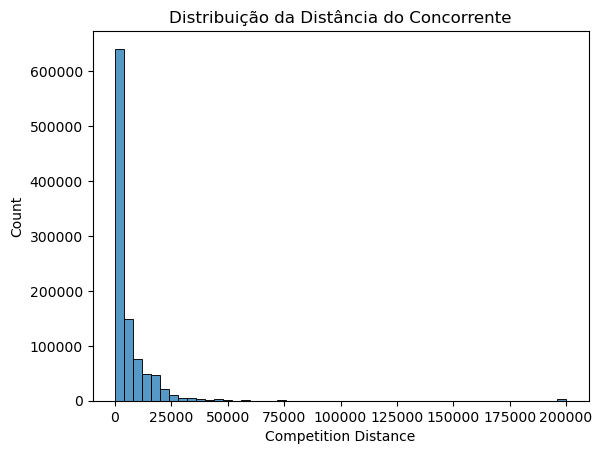

In [39]:
sns.histplot(df1['competition_distance'], bins=50)
plt.xlabel('Competition Distance')
plt.title('Distribuição da Distância do Concorrente')
plt.show()

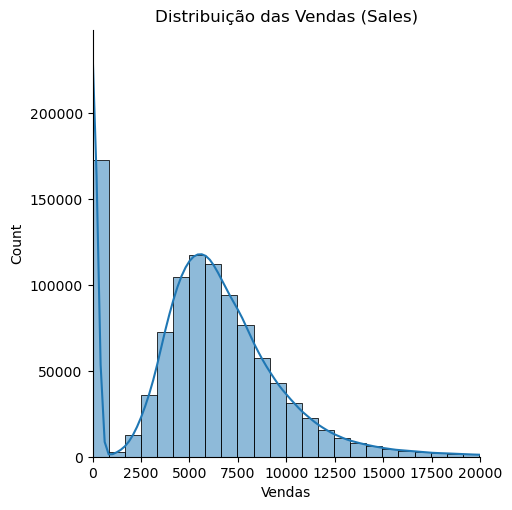

In [40]:
sns.displot(df1['sales'], bins=50, kde=True)
plt.xlim(0, 20000)
plt.title('Distribuição das Vendas (Sales)')
plt.xlabel('Vendas')
plt.show()

### 1.7.2 Estatistica descritiva categórica

In [41]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_str                       12
dtype: int64

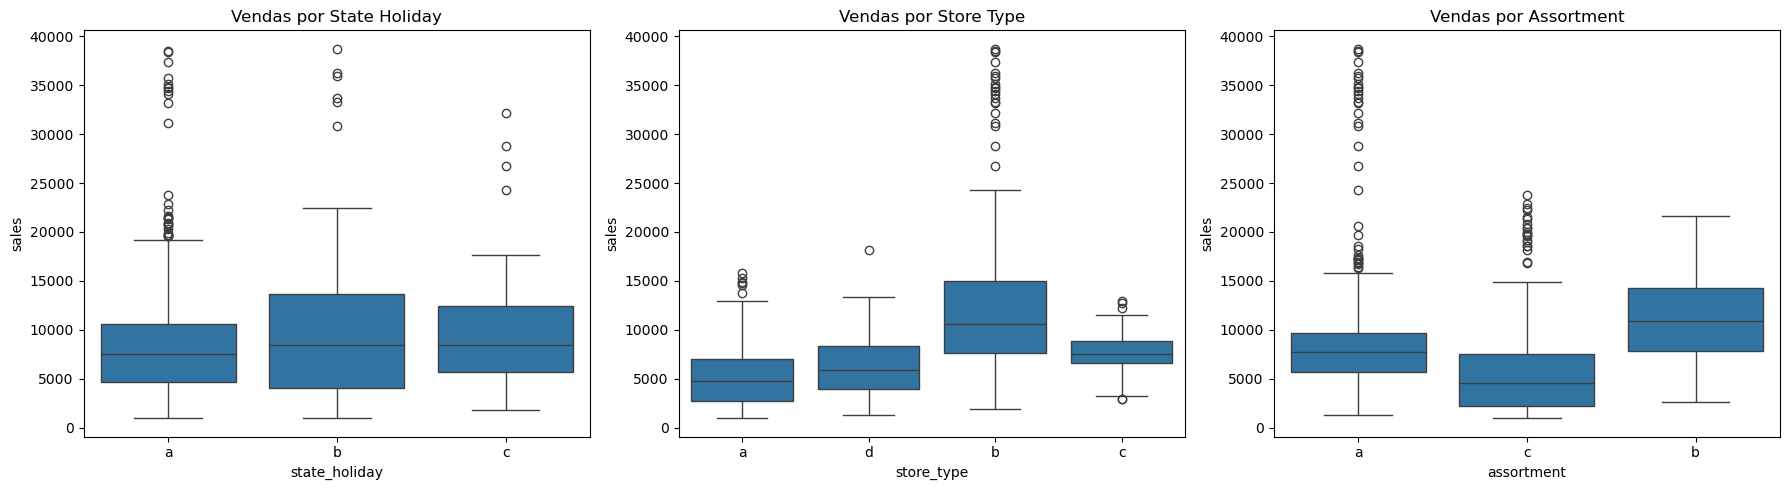

In [42]:
plt.figure(figsize=(18, 5))

aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)
plt.title('Vendas por State Holiday')

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)
plt.title('Vendas por Store Type')

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)
plt.title('Vendas por Assortment')

plt.tight_layout()
plt.show()

📊 Boxplot → MEDAS

   └─ M → Mediana (linha central): Quem vende mais?

   └─ E → Espaço da caixa: Dispersão (estável ou instável?)

   └─ D → Dados extremos (outliers): Muitos valores atípicos?

   └─ A → Assimetria: A caixa está mais para cima ou para baixo?
   
   └─ S → Subgrupos: Qual categoria se destaca? Por quê?


### Continuar do Módulo 03 - Feature Enginnering - 1. Aula 08 Mindmap de hipóteses

Feature Enginnering: Ter as variáveis DISPONÍVEIS para ESTUDO durante a EDA.

Mapa mental de hipóteses:

* Fenômeno: Qual é o fenômeno que estou modelando?

* Agentes: Quemsão os agentes que atuam sobre o fenômeno de interesse?

* Atributo dos agentes: Descrição dos agentes?

* Lista de hipóteses: Hipóteses para validar os dados

# 2.0. Passo 02 - FEATURE ENGINNERING

* Hipótses são apostas

    - Lojas de MAIOR porte...
    deveriam vender MAIS.

    - Lojas com MAIOR sortimento...
    deveriam vender MAIS.

# 2.1. Criação de Hipóteses

## 2.1.1. Hipóteses Loja

**1.** Loja com maior quadro de funcionários deveriam vender mais

**2.** Loja com maior capacidade de estoque deveriam vender mais

**3.** Loja com maior porte deveriam vender mais

**4.** Loja com maior sortimento deveriam vender mais

**5.** Loja com competidores mais proximos deveriam vender menos

**6.** Loja com competidores a mais tempo deveriam vender mais

## 2.1.2. Hipóteses Produto

**1.** Loja que investem mais e Marketing deveriam vender mais

**2.** Loja com maior exposição de produtos deveriam vender mais

**3.** Loja que tem preços menores nos produtos deveriam vender mais

**4.** Loja com promoções agressivas (descontos maiores) deveriam vender mais

**5.** Loja com promoções ativas por mais tempo deveriam vender mais

**6.** Loja com mais dias de promoção deveriam vender mais

**7.** Loja com mais promoções consecutivas deveriam vender mais


## 2.1.3. Hipóteses Tempo

**1.** Loja abertas durante o feriado de Natal deveriam vender mais

**2.** Loja deveriam vender mais ao longo dos anos

**3.** Loja deveriam vender mais no segundo semestre do ano

**4.** Loja deveriam vender mais depois do dia 10 de cada mês

**5.** Loja deveriam vender menos aos finais de semana

**6.** Loja deveriam vender menos durante os feriados escolares

# 2.2. Priorização das hipóteses: O que já temos disponível?

**1.** Loja com maior sortimento deveriam vender mais

**2.** Loja com competidores mais proximos deveriam vender menos

**3.** Loja com competidores a mais tempo deveriam vender mais

**4.** Loja com promoções ativas por mais tempo deveriam vender mais

**5.** Loja com mais dias de promoção deveriam vender mais

**6.** Loja com mais promoções consecutivas deveriam vender mais

**7.** Loja abertas durante o feriado de Natal deveriam vender mais

**8.** Loja deveriam vender mais ao longo dos anos

**9.** Loja deveriam vender mais no segundo semestre do ano

**10.** Loja deveriam vender mais depois do dia 10 de cada mês

**11.** Loja deveriam vender menos aos finais de semana

**12.** Loja deveriam vender menos durante os feriados escolares

In [43]:
df2 = df1.copy()

## 2.3. Feature Engineering

In [44]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# yeer week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public' if x == 'a' else 'easter' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [45]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## Continuar de: Aula 11 - Filtragem de variáveis

## Filtragem de variáveis x Seleção de variáveis 

- Filtragem de variáveis: restrições de acordo com o negócio

- Seleção de variáveis: variáveis mais relevantes para o modelo

## 3.0. Passo 03 - Filtragem de variáveis

In [46]:
pd.set_option('display.max_columns', None)

In [47]:
df3 = df2.copy()

In [48]:
df3.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_str,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279


### 3.1. Filtragem das linhas

In [49]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Seleção das colunas

In [50]:
# Colunas a serem removidas
cols_drop = ['customers', 'open', 'promo_interval', 'month_str']

df3 = df3.drop(cols_drop, axis=1)

In [51]:
df3.sample(5)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
296254,40,2,2014-10-28,5065,0,regular_day,0,a,basic,180.0,10,2014,1,45,2009,0,2014,10,28,44,2014-43,2014-10-01,0,2009-11-02,260
734893,894,3,2013-09-11,10918,1,regular_day,0,a,basic,190.0,11,2012,0,37,2013,0,2013,9,11,37,2013-36,2012-11-01,10,2013-09-09,0
748195,816,5,2013-08-30,6884,1,regular_day,1,c,extended,460.0,8,2013,0,35,2013,0,2013,8,30,35,2013-34,2013-08-01,0,2013-08-26,0
621617,233,6,2013-12-21,10503,0,regular_day,0,a,basic,1890.0,12,2013,0,51,2013,0,2013,12,21,51,2013-50,2013-12-01,0,2013-12-16,0
271318,408,1,2014-11-24,6032,1,regular_day,0,c,basic,1560.0,11,2014,1,45,2009,1,2014,11,24,48,2014-47,2014-11-01,0,2009-11-02,264


Fazer uma análise entre os gráficos (maior ou menor significa o que?)

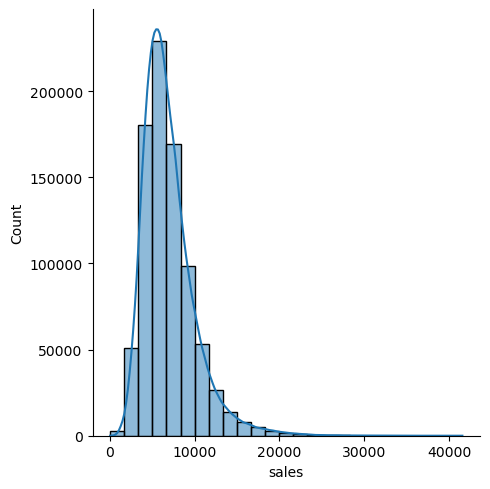

In [52]:
sns.displot(df3['sales'], bins=25, kde=True)

## Continuar: Módulo 04 - Exploratory Data Analysis - Aula 12

1. Como as variáveis impactam o fenomêno?

2. Qual é a força desse impacto?

### Quais os 3 objetivos da EDA?

* Ganhar experiência de negócio.

* Validar hipoteses de negócios (insights).

* Perceber quais variáveis que são importantes para o modelo.

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [53]:
df4 = df3.copy()

## Análise Univaraida

### 4.1.1. Variável resposta

Premissas de ML: variáveis independentes, variável resposta seguindo uma distribuição normal

<Axes: xlabel='sales', ylabel='Count'>

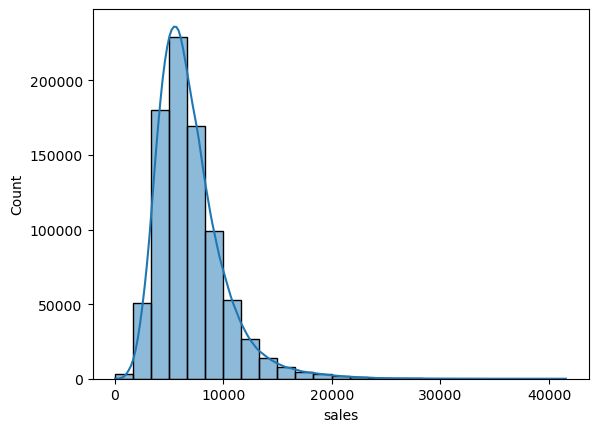

In [54]:
sns.histplot(df4['sales'], bins=25, kde=True)

<Axes: xlabel='sales', ylabel='Count'>

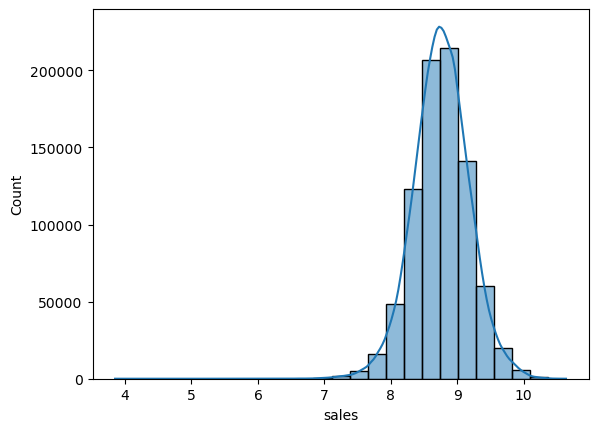

In [55]:
# Deslocando a distribuição para evitar valores zero
sns.histplot(np.log1p(df4['sales']), bins=25, kde=True)

### 4.1.2 Variável numérica

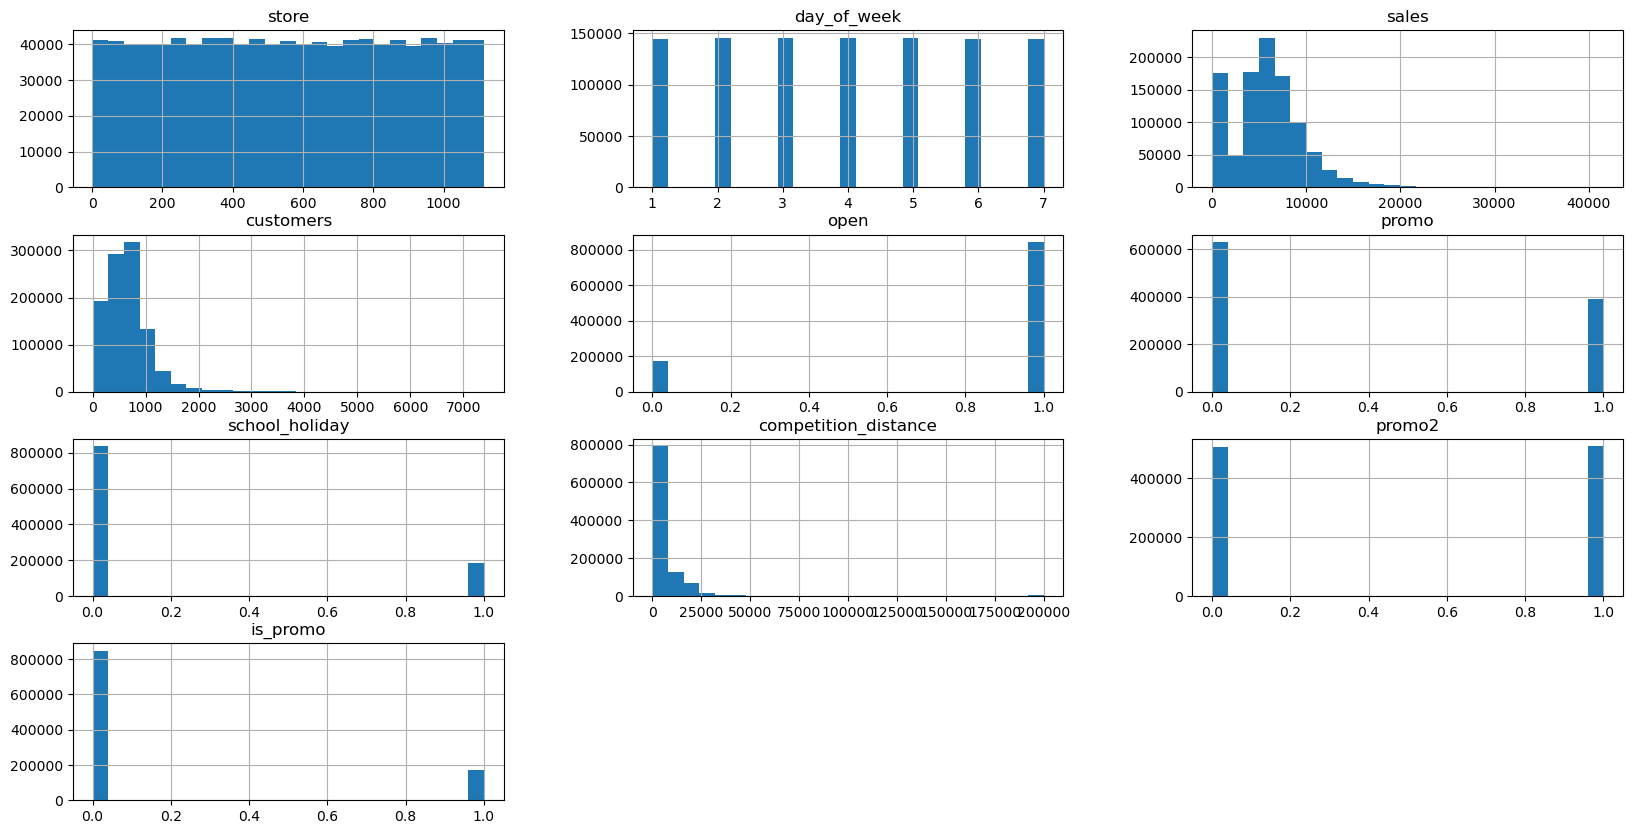

In [56]:
num_attributes.hist(figsize=(20, 10), bins=25);

### 4.1.3 Variável categorica

In [57]:
cat_attributes.head()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_str
0,0,c,a,9,2008,31,2015,0,Jul
1,0,a,a,11,2007,13,2010,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,12,2006,14,2011,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,9,2009,31,2015,0,Jul
4,0,a,a,4,2015,31,2015,0,Jul


In [58]:
df4['state_holiday'].drop_duplicates()

0         regular_day
63559          public
129424         easter
241126      christmas
Name: state_holiday, dtype: object

### Feito na aula

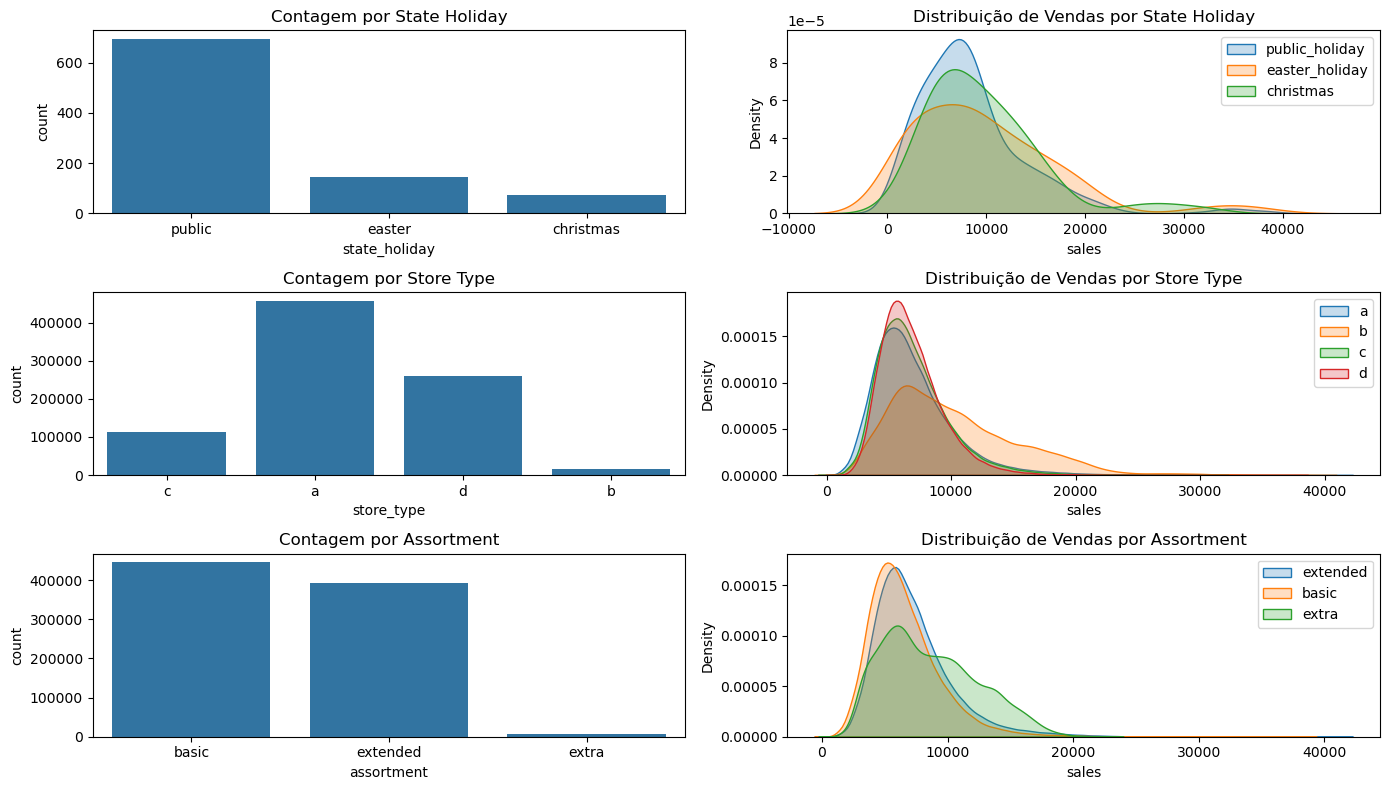

In [59]:
plt.figure(figsize=(14, 8))

# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x='state_holiday', data=a)
plt.title('Contagem por State Holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.legend()
plt.title('Distribuição de Vendas por State Holiday')

# store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)
plt.title('Contagem por Store Type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.legend()
plt.title('Distribuição de Vendas por Store Type')

# assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)
plt.title('Contagem por Assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True)
plt.legend()
plt.title('Distribuição de Vendas por Assortment')

plt.tight_layout()
plt.show()

## CONTINUAR DA AULA 2. Aula 13 - Análise exploratória de dados - Parte I

In [60]:
df5 = df4.copy()

## Análise Bivariada

Como a variável impacta na resposta?

### **H1.** Loja com maior sortimento deveriam vender mais

**FALSA** Lojas com maior sortimento vendem MENOS.

Text(0.5, 1.0, 'Vendas por Assortment')

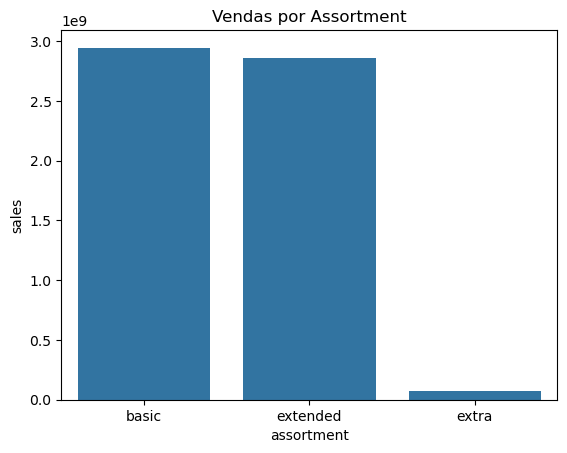

In [61]:
# H1. Loja com maior sortimento deveriam vender mais

aux1 = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)
plt.title('Vendas por Assortment')

# Resposta H1: Ter maior sortimento não necessariamente significa vender mais, pois o assortment 'extra' tem 
# vendas menores que 'basic' e 'extended', apesar de ser o mais completo.

In [62]:
aux2 = df5[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()


In [63]:
aux2.head(6)

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
5,2013-01,extra,350279


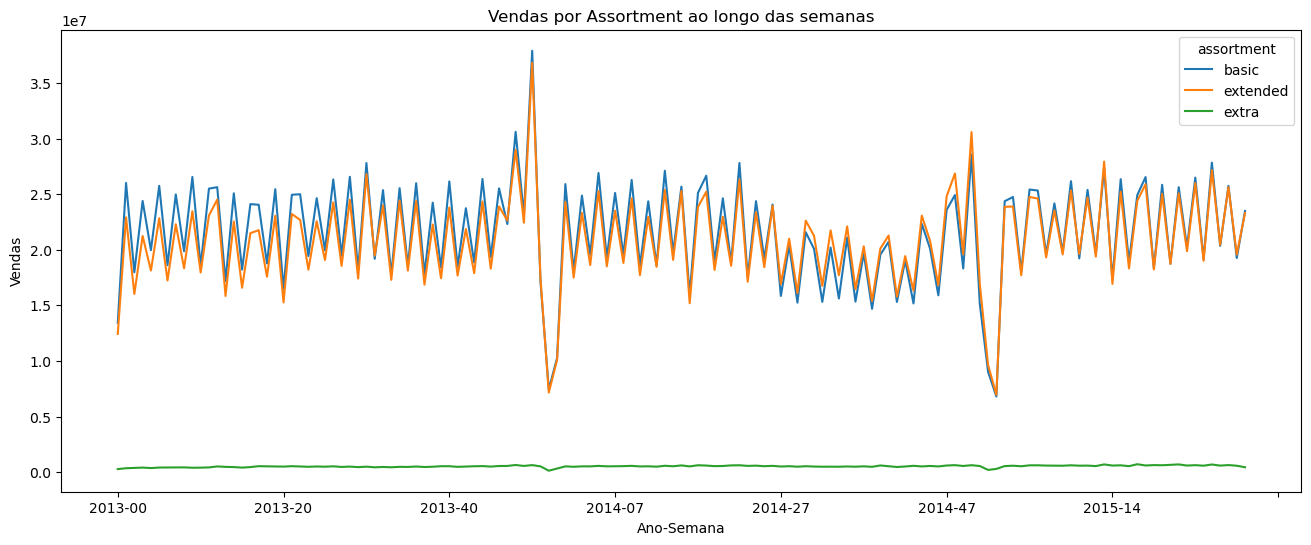

In [64]:
aux3 = aux2.pivot(index='year_week', columns='assortment', values='sales')
aux3.plot(kind='line', figsize=(16, 6))
plt.title('Vendas por Assortment ao longo das semanas')
plt.ylabel('Vendas')
plt.xlabel('Ano-Semana')
plt.show()

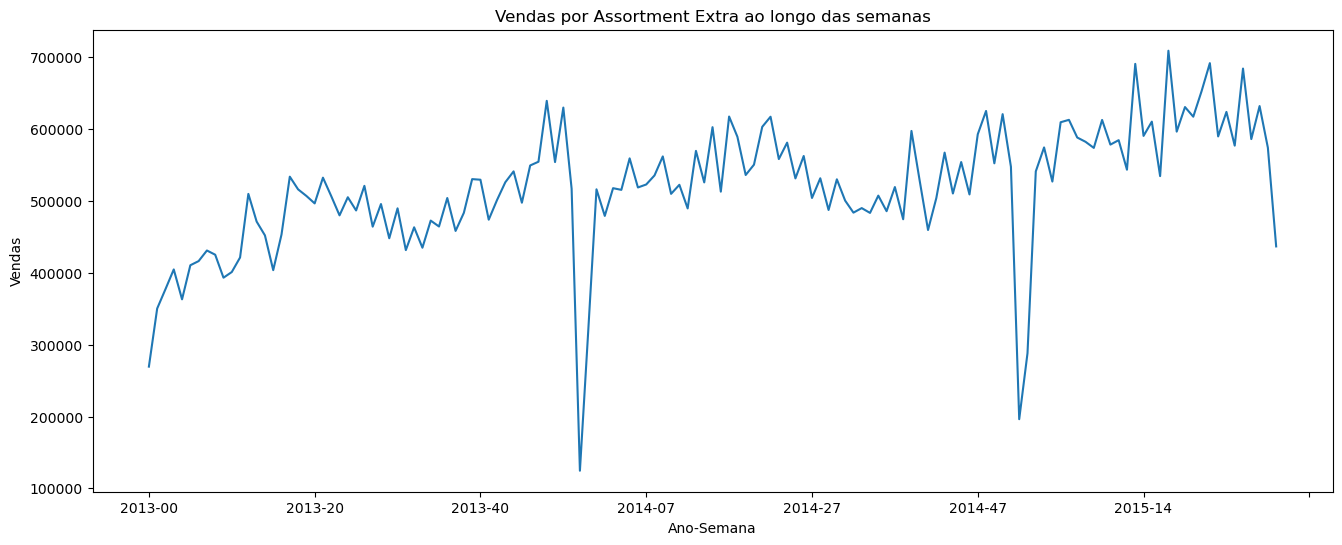

In [65]:
# Seleciona apenas a coluna 'extra' do DataFrame pivotado aux3
aux4 = aux3['extra']
aux4.plot(kind='line', figsize=(16, 6))
plt.title('Vendas por Assortment Extra ao longo das semanas')
plt.ylabel('Vendas')
plt.xlabel('Ano-Semana')
plt.show()

### **H2.** Loja com competidores mais proximos deveriam vender menos

**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

C:\Users\Giovanna\AppData\Local\Temp\ipykernel_8484\2492553955.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = df5.groupby('competition_distance_binned')['sales'].sum().reset_index()


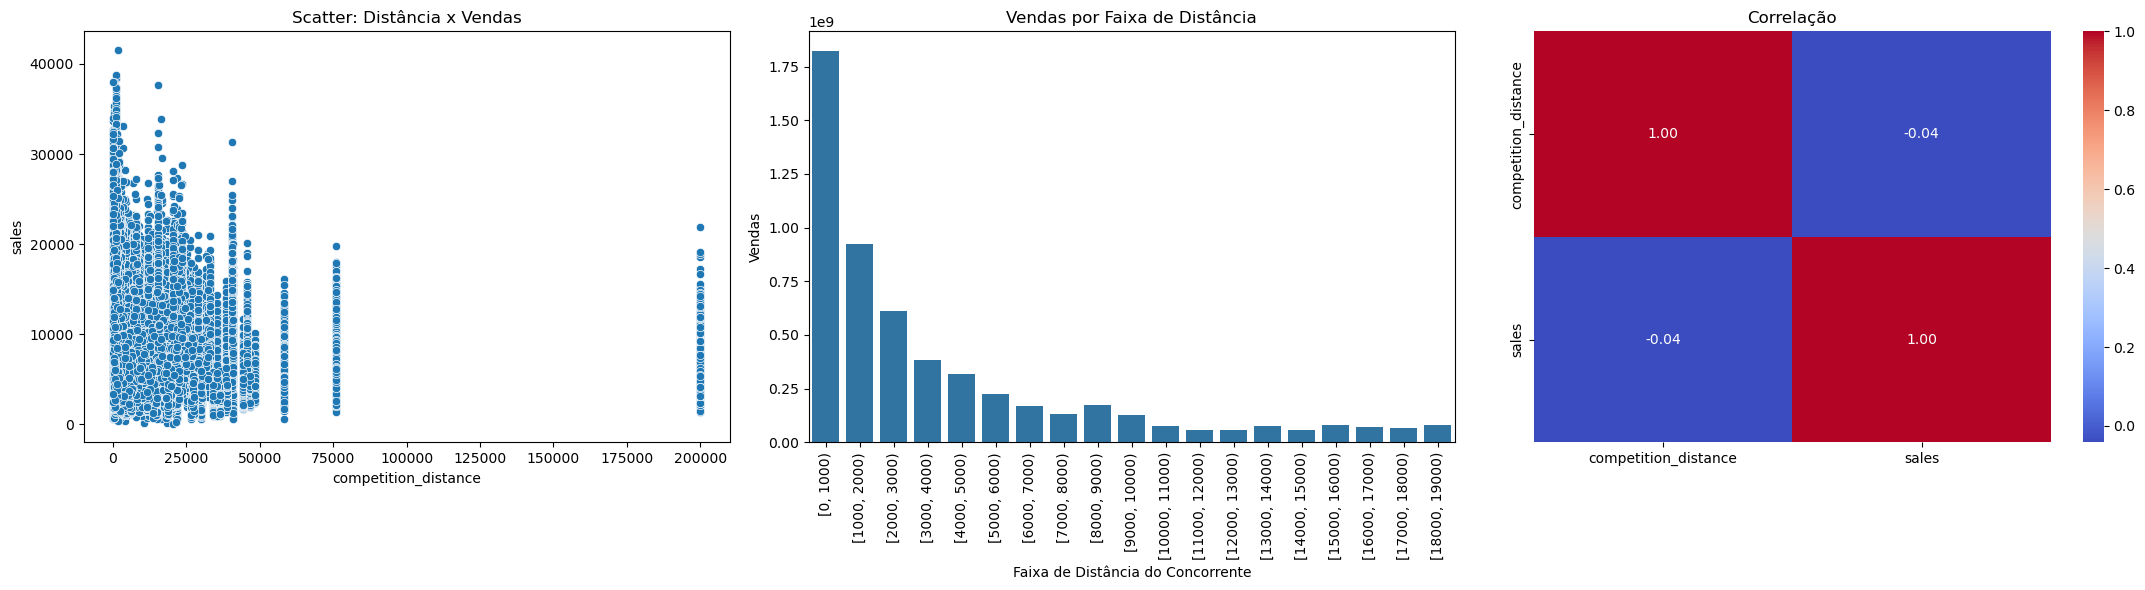

In [66]:
# Cria faixas (bins) para competition_distance
bins = list(np.arange(0, 20000, 1000))#[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 200000]
'''labels = [
	'0-10k', '10k-20k', '20k-30k', '30k-40k', '40k-50k', '50k-60k',
	'60k-70k', '70k-80k', '80k-90k', '90k-100k', '100k-200k'
]  labels=labels,'''
df5['competition_distance_binned'] = pd.cut(df5['competition_distance'], bins=bins, include_lowest=True, right=False)

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# 1. Scatterplot
sns.scatterplot(x='competition_distance', y='sales', data=df5, ax=axes[0])
axes[0].set_title('Scatter: Distância x Vendas')

# 2. Barplot (binned)
# Agrupar vendas por faixa de distância
aux2 = df5.groupby('competition_distance_binned')['sales'].sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2, ax=axes[1])
axes[1].set_title('Vendas por Faixa de Distância')
axes[1].set_xlabel('Faixa de Distância do Concorrente')
axes[1].set_ylabel('Vendas')
axes[1].tick_params(axis='x', rotation=90)

# 3. Heatmap de correlação
sns.heatmap(df5[['competition_distance', 'sales']].corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[2])
axes[2].set_title('Correlação')

plt.tight_layout()
plt.show()


### **H3.** Loja com competidores a mais tempo deveriam vender mais

**FALSO** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS.

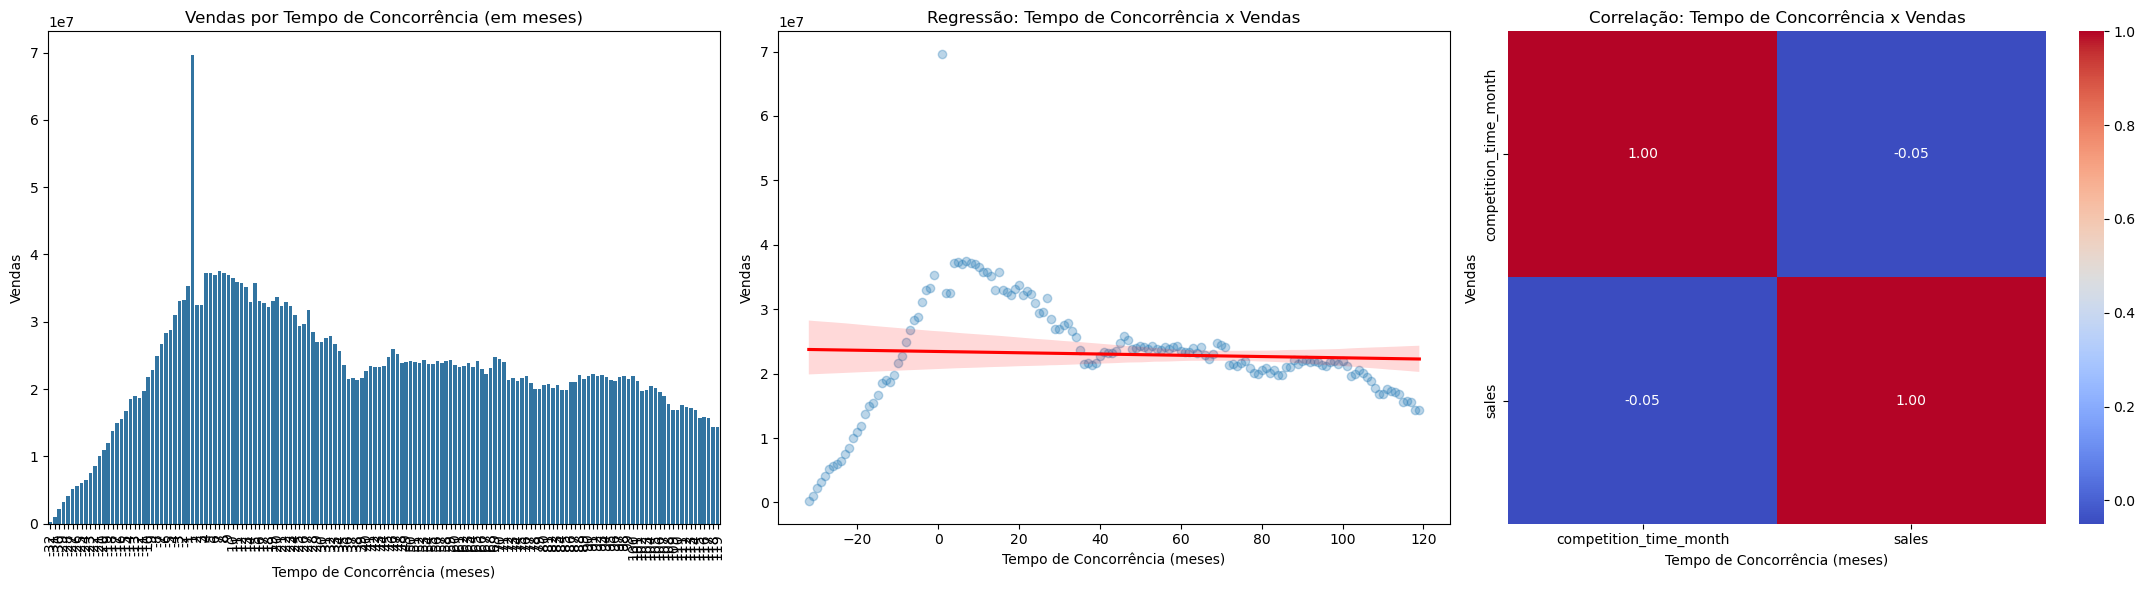

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# 1. Barplot: Vendas por Tempo de Concorrência (em meses)
aux1 = df5[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2, ax=axes[0])
axes[0].set_title('Vendas por Tempo de Concorrência (em meses)')
axes[0].set_xlabel('Tempo de Concorrência (meses)')
axes[0].set_ylabel('Vendas')
axes[0].tick_params(axis='x', rotation=90)

# 2. Regressão: Relação entre Tempo de Concorrência e Vendas
sns.regplot(x='competition_time_month', y='sales', data=aux2, scatter_kws={'alpha':0.3}, line_kws={'color':'red'}, ax=axes[1])
axes[1].set_title('Regressão: Tempo de Concorrência x Vendas')
axes[1].set_xlabel('Tempo de Concorrência (meses)')
axes[1].set_ylabel('Vendas')

# 3. Espaço reservado para outro gráfico
sns.heatmap(aux2.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[2])
axes[2].set_title('Correlação: Tempo de Concorrência x Vendas')
axes[2].set_xlabel('Tempo de Concorrência (meses)')
axes[2].set_ylabel('Vendas')
axes[2].tick_params(axis='x')


plt.tight_layout()
plt.show()

### **H4.** Loja com promoções ativas por mais tempo deveriam vender mais

**Falso** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período.

In [68]:
from matplotlib.gridspec import GridSpec

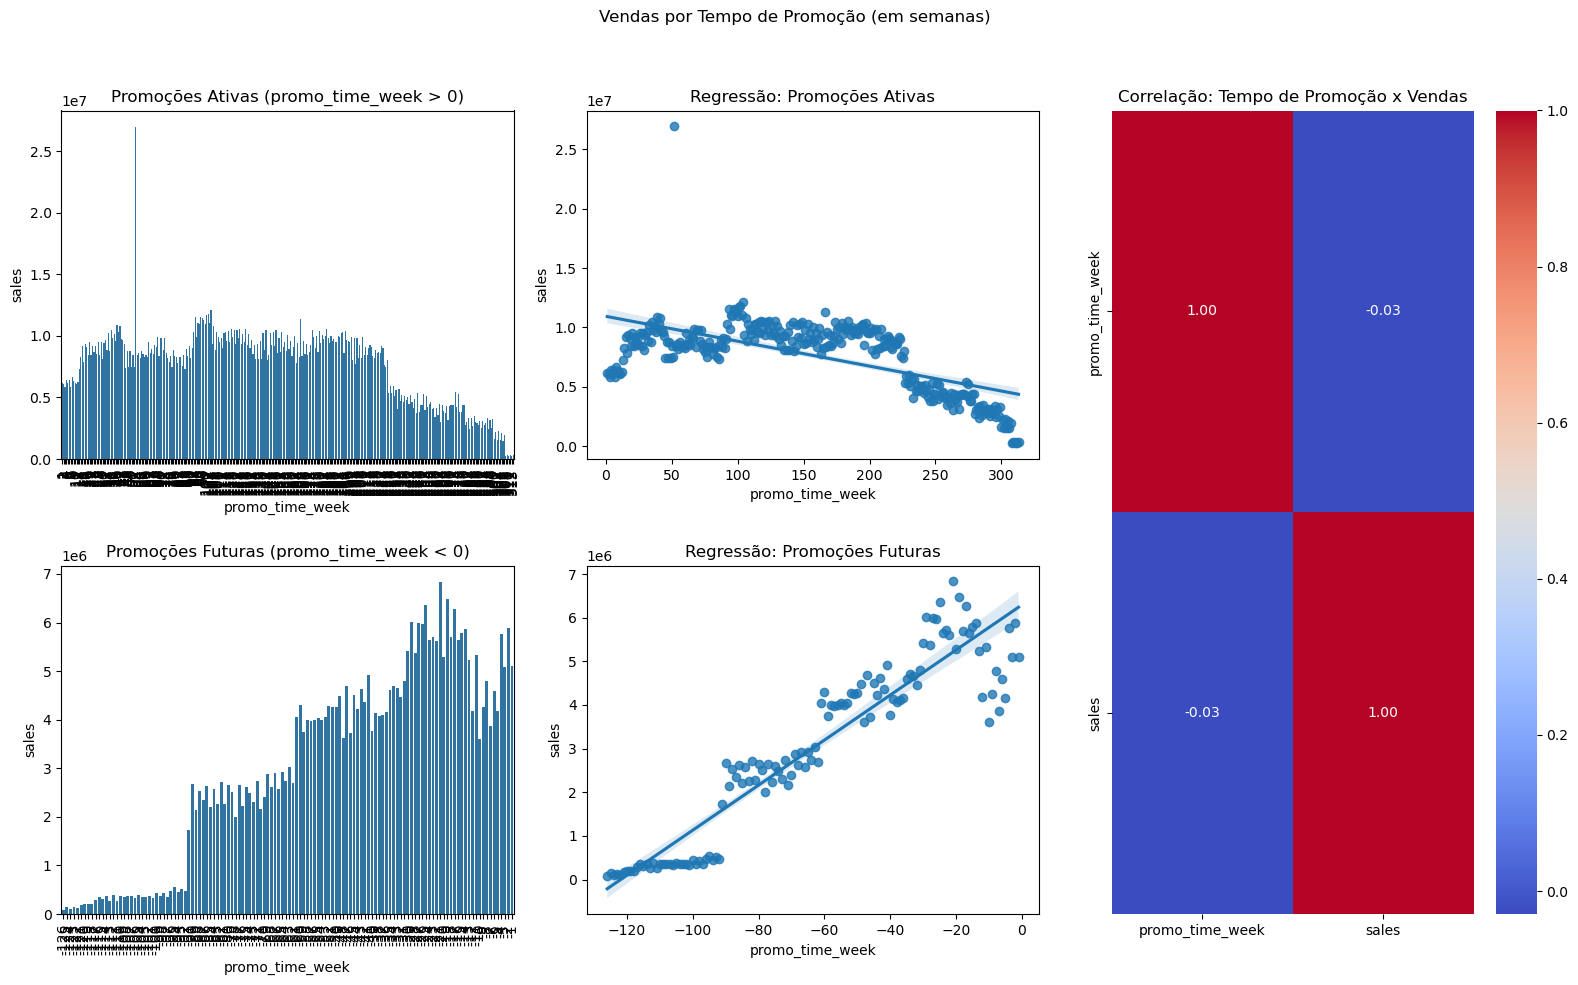

In [69]:
aux1 = df5[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(16, 10))
plt.suptitle('Vendas por Tempo de Promoção (em semanas)')

grid = GridSpec(figure=(16, 10), nrows=2, ncols=3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Promoções Ativas (promo_time_week > 0)')
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)
plt.title('Regressão: Promoções Ativas')

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Promoções Futuras (promo_time_week < 0)')
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)
plt.title('Regressão: Promoções Futuras')

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação: Tempo de Promoção x Vendas')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### <s>**H5.** Loja com mais dias de promoção deveriam vender mais </s>


### **H6.** Loja com mais promoções consecutivas deveriam vender mais

**Falso** Lojas com mais promoções consecutivas VENDEM MENOS.

In [70]:
df5[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index().sort_values('sales', ascending=True)

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


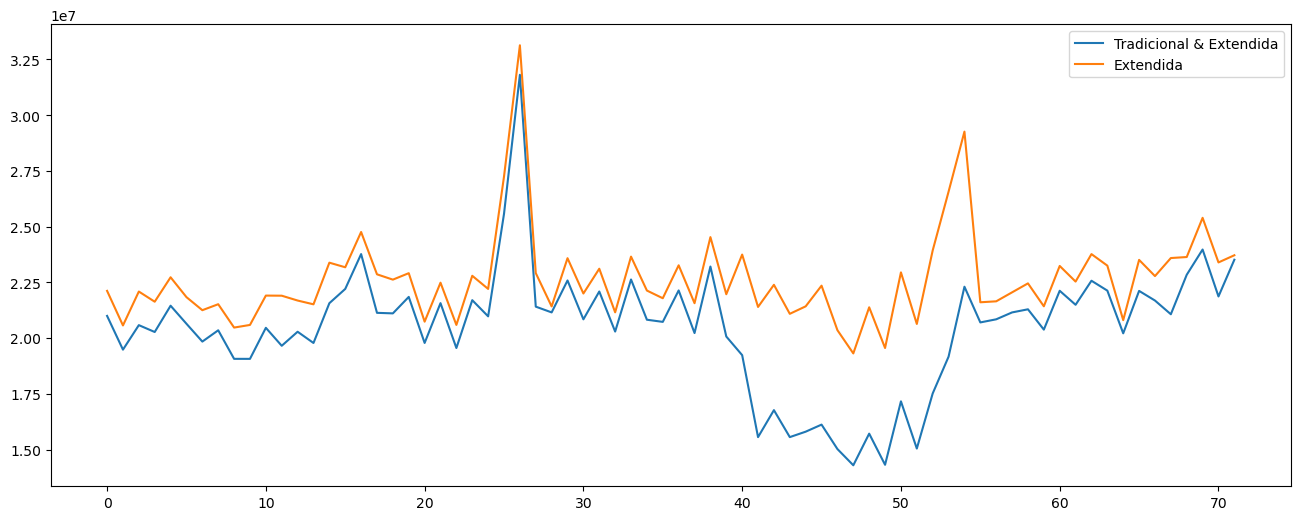

In [71]:
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(kind='line', figsize=(16, 6))

aux2 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(kind='line', figsize=(16, 6), ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

Como as variáveis se relacionam?

### **H7.** Loja abertas durante o feriado de Natal deveriam vender mais

**Falso** Lojas abertas durante o feriado de natal vendem menos

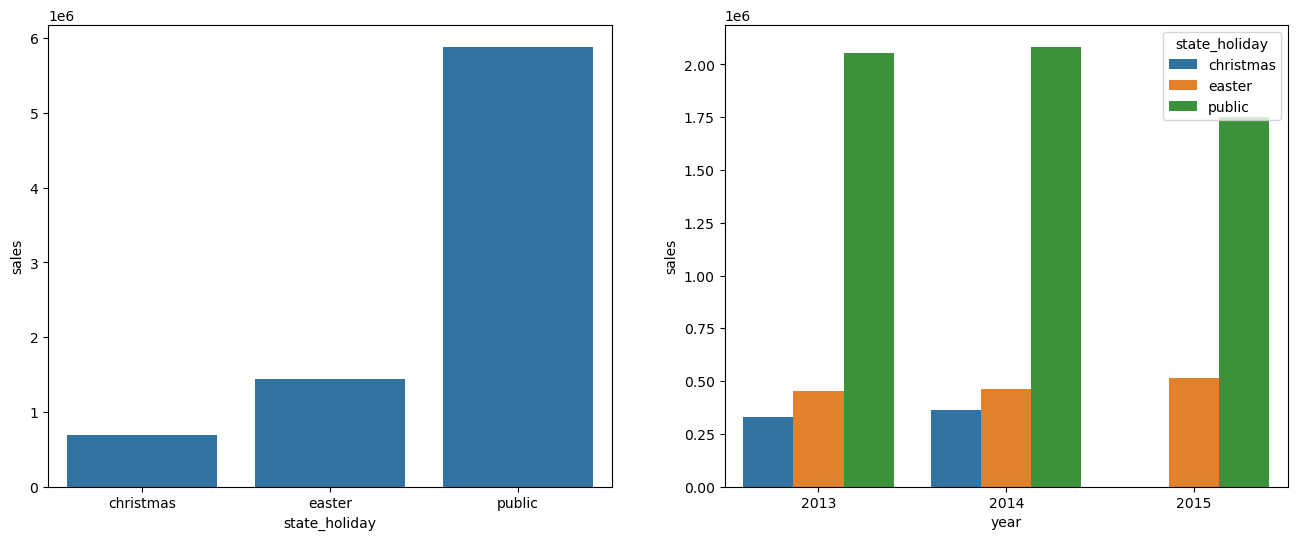

In [72]:
aux = df5[df5['state_holiday'] != 'regular_day'] # Retirando os dias normais para melhor visualização

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Loja deveriam vender mais ao longo dos anos

**Falso** Lojas vendem MENOS ao longo dos anos

<Axes: >

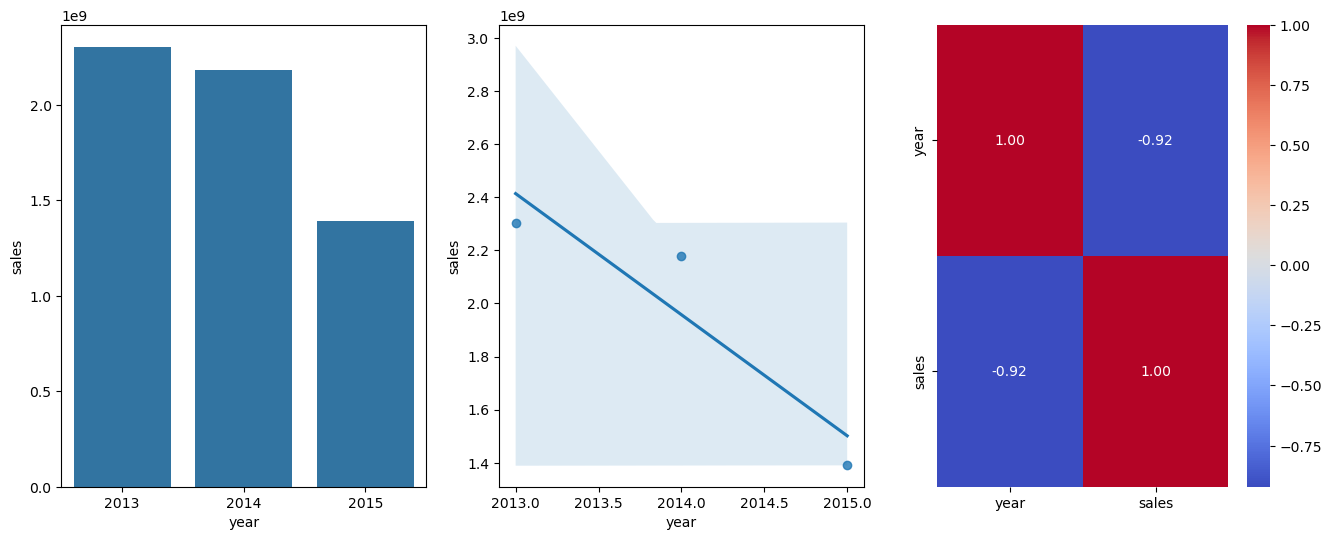

In [73]:
aux1 = df5[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

### **H9.** Loja deveriam vender mais no segundo semestre do ano

**FALSO** Lojas vendem MENOS no segundo semestre do ano

<Axes: >

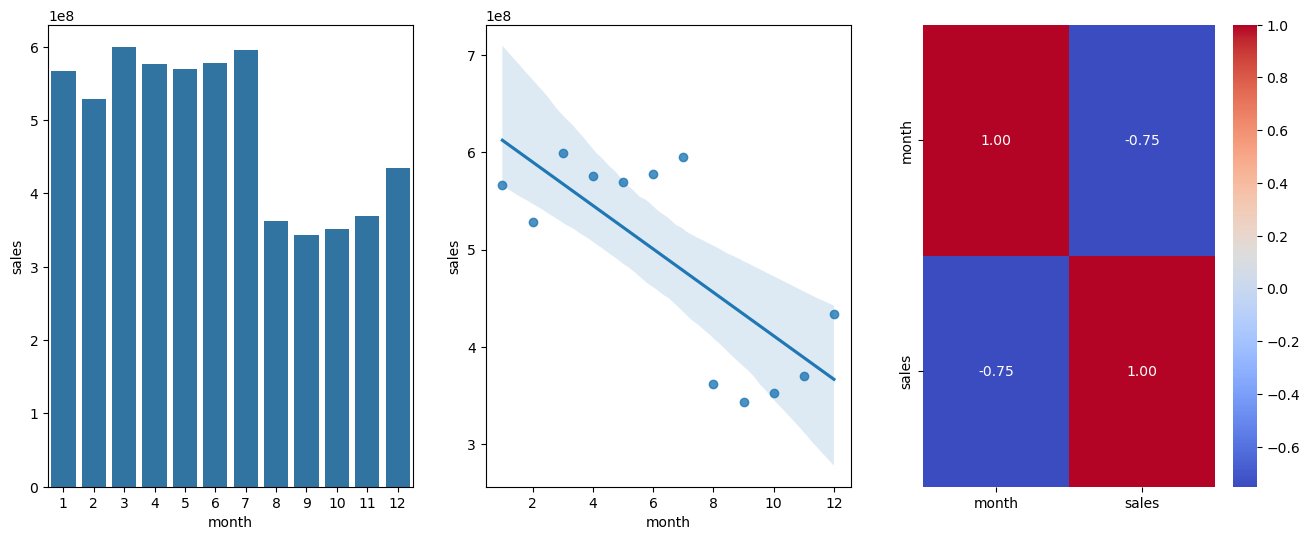

In [74]:
aux1 = df5[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

### **H10.** Loja deveriam vender mais depois do dia 10 de cada mês

**Verdadeira** Lojas vendem mais depois do dia 10 de cada mês 

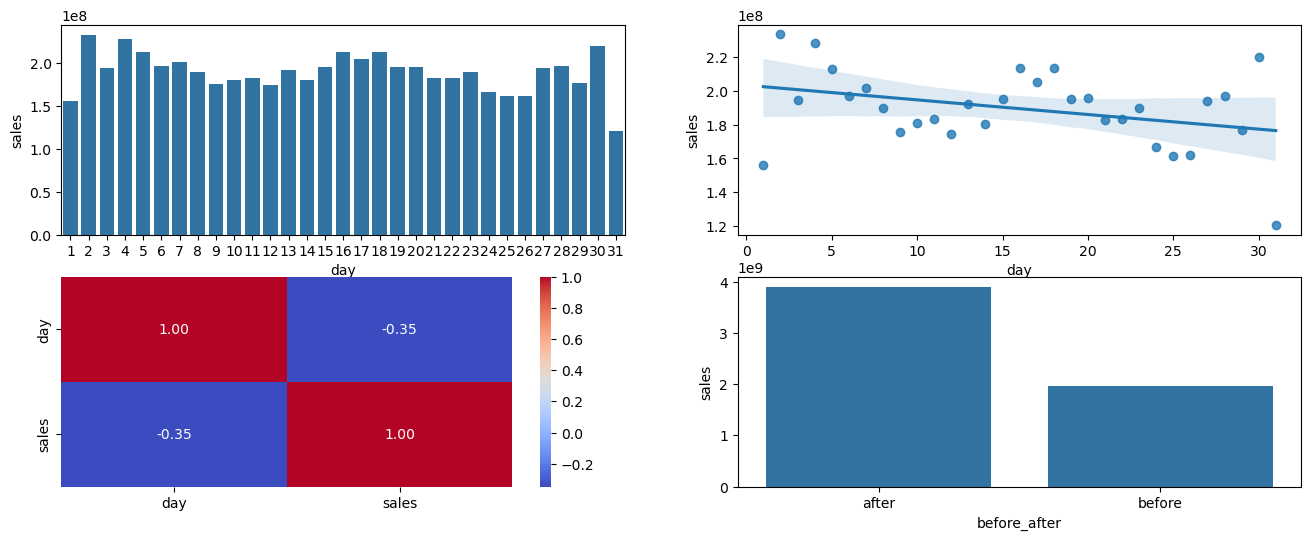

In [75]:
aux1 = df5[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Loja deveriam vender menos aos finais de semana

**Verdadeiro** Lojas vendem MENOS nos finais de semana

<Axes: >

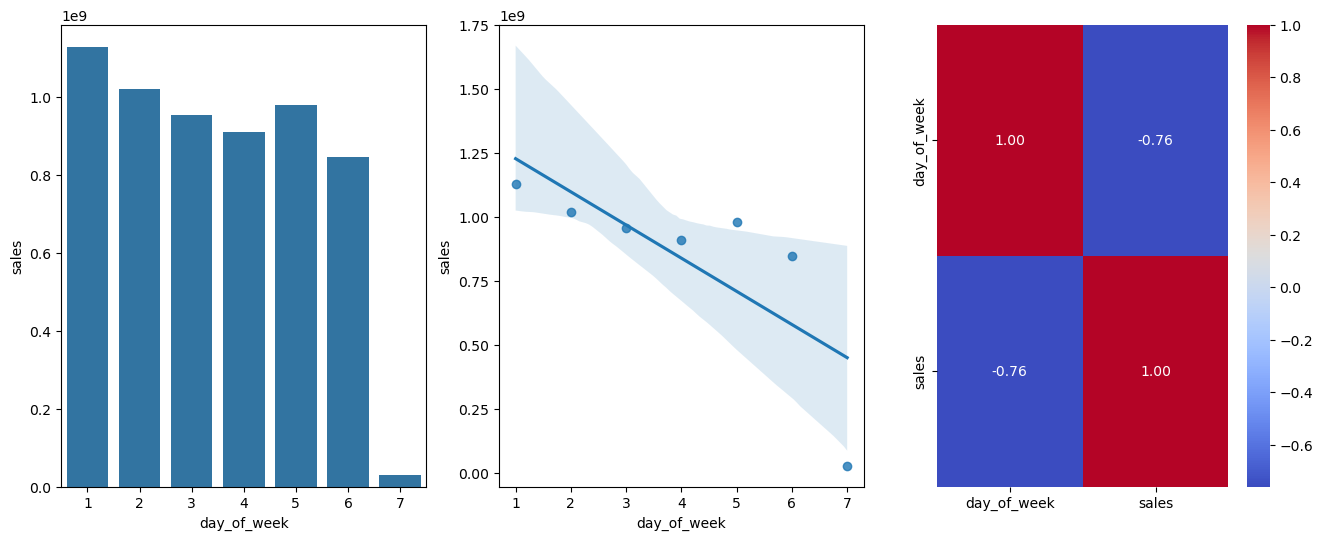

In [76]:
aux1 = df5[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

### **H12.** Loja deveriam vender menos durante os feriados escolares

**Verdadeira** Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto.

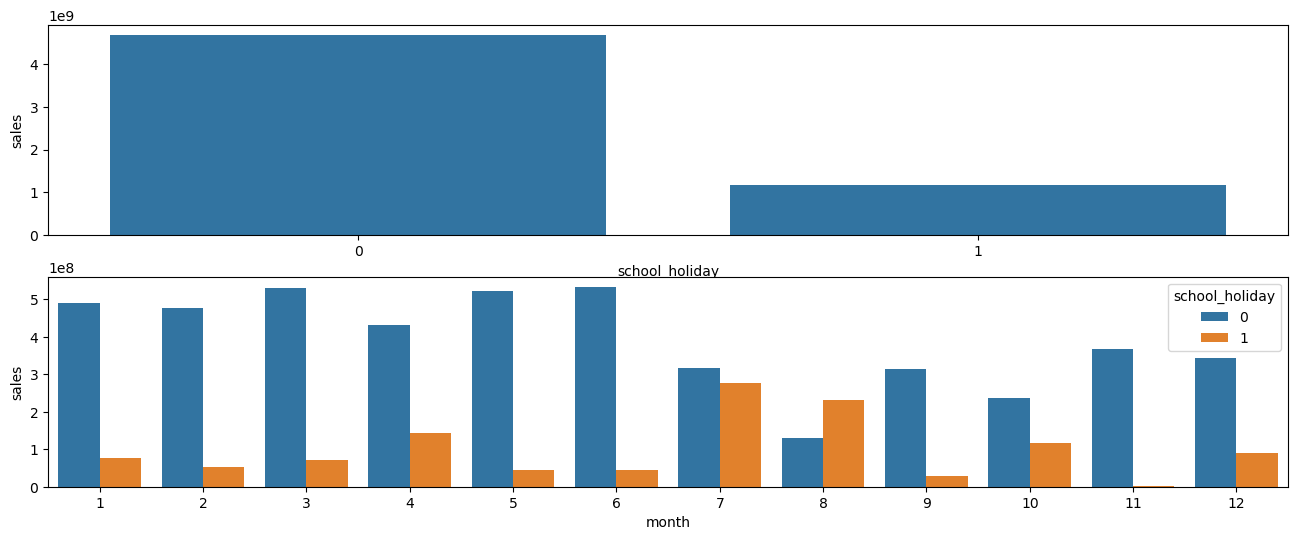

In [77]:
plt.figure(figsize=(16, 6))

plt.subplot(2, 1, 1)
aux1 = df5[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df5[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

# plt.subplot(1, 3, 3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True, cmap='coolwarm', fmt='.2f')

In [81]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
         ['H1', 'Falsa', 'Baixa'],
         ['H2', 'Falsa', 'Media'],
         ['H3', 'Falsa', 'Media'],
         ['H4', 'Falsa', 'Baixa'],
         ['H5', '--', '--'],
         ['H6', 'Falsa', 'Baixa'],
         ['H7', 'Falsa', 'Media'],
         ['H8', 'Falsa', 'Alta'],
         ['H9', 'Falsa', 'Alta'],
         ['H10', 'Falsa', 'Alta'],
         ['H11', 'Falsa', 'Alta'],
         ['H12', 'Falsa', 'Baixa']]

print(tabulate(tab, headers='firstrow', tablefmt='grid', stralign='center', numalign='center'))

+-------------+-------------+--------------+
|  Hipoteses  |  Conclusão  |  Relevância  |
+=============+=============+==============+
|     H1      |    Falsa    |    Baixa     |
+-------------+-------------+--------------+
|     H2      |    Falsa    |    Media     |
+-------------+-------------+--------------+
|     H3      |    Falsa    |    Media     |
+-------------+-------------+--------------+
|     H4      |    Falsa    |    Baixa     |
+-------------+-------------+--------------+
|     H5      |     --      |      --      |
+-------------+-------------+--------------+
|     H6      |    Falsa    |    Baixa     |
+-------------+-------------+--------------+
|     H7      |    Falsa    |    Media     |
+-------------+-------------+--------------+
|     H8      |    Falsa    |     Alta     |
+-------------+-------------+--------------+
|     H9      |    Falsa    |     Alta     |
+-------------+-------------+--------------+
|     H10     |    Falsa    |     Alta     |
+---------

## Análise Multivariada

### 4.3.1. Numerical Attribuites

<Axes: >

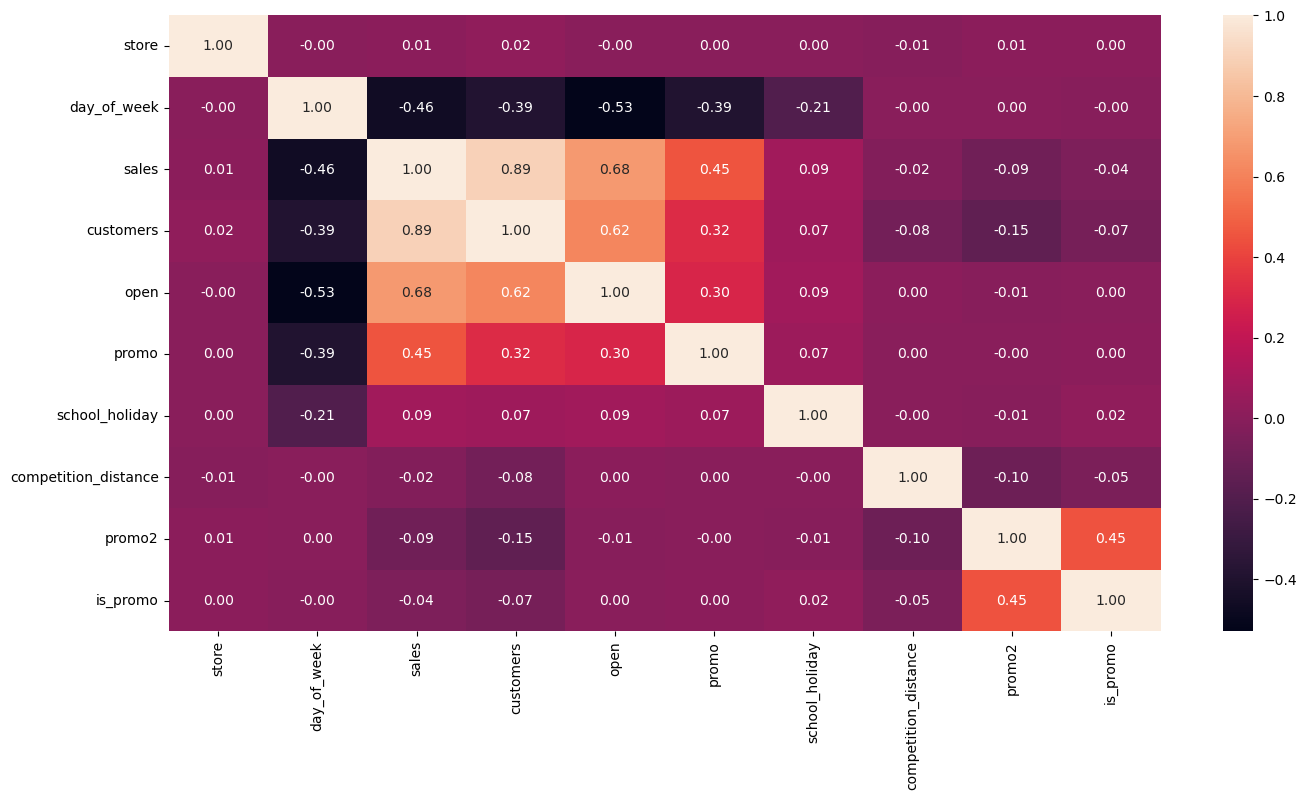

In [82]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(16, 8))
sns.heatmap(correlation, annot=True, fmt='.2f')

### 4.3.1. Categorical Attribuites

In [83]:
# only categorical attributes
a = df5.select_dtypes(include='object')

In [84]:
a1 = v_crameer(a['state_holiday'], a['state_holiday'])
a2 = v_crameer(a['state_holiday'], a['store_type'])
a3 = v_crameer(a['state_holiday'], a['assortment'])

a4 = v_crameer(a['store_type'], a['state_holiday'])
a5 = v_crameer(a['store_type'], a['store_type'])
a6 = v_crameer(a['store_type'], a['assortment'])

a7 = v_crameer(a['assortment'], a['state_holiday'])
a8 = v_crameer(a['assortment'], a['store_type'])
a9 = v_crameer(a['assortment'], a['assortment'])

d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
})

d = d.set_index(d.columns)

Text(0.5, 1.0, "Cramer's V Correlation Matrix")

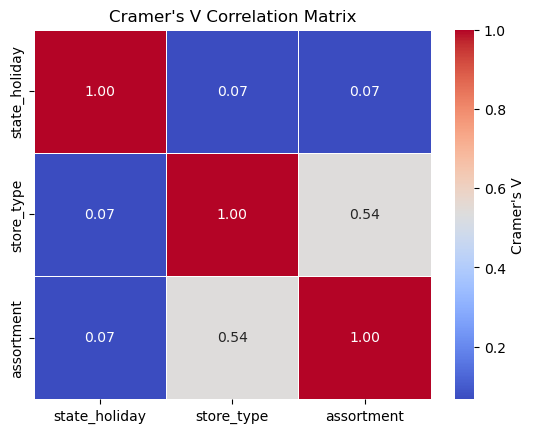

In [85]:
sns.heatmap(d, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Cramer\'s V'}, linewidths=.5)
plt.title('Cramer\'s V Correlation Matrix')